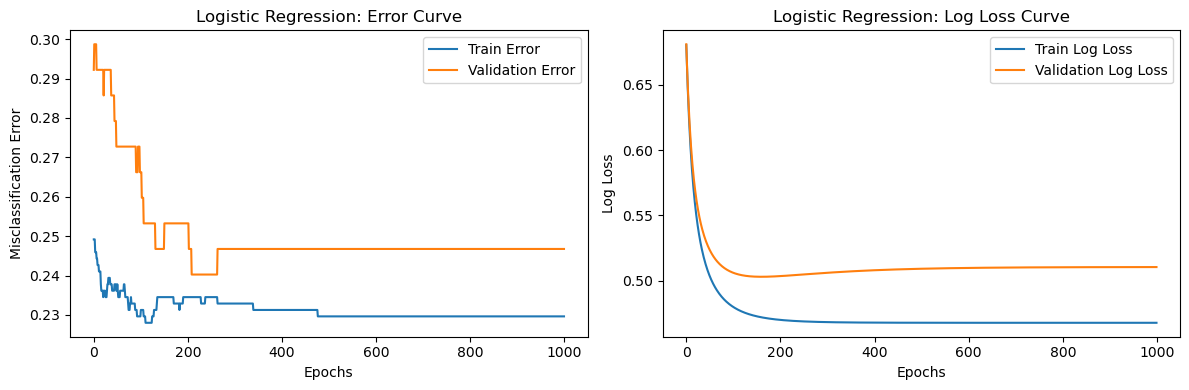

=== Logistic Regression Evaluation ===
Confusion Matrix:
 [[79 20]
 [18 37]]
Accuracy: 0.7532467532467533
Precision: 0.6491228070175439
Recall: 0.6727272727272727
F1 Score: 0.6607142857142857



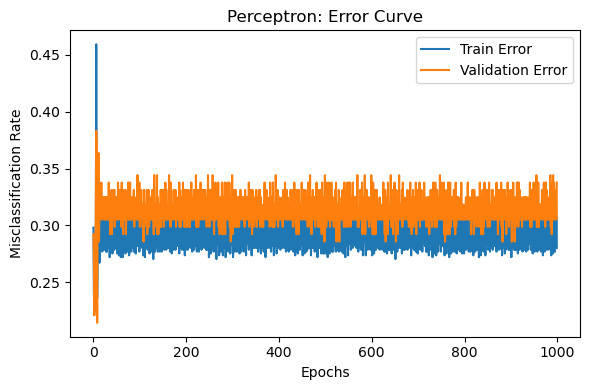

=== Perceptron Evaluation ===
Confusion Matrix:
 [[69 30]
 [22 33]]
Accuracy: 0.6623376623376623
Precision: 0.5238095238095238
Recall: 0.6
F1 Score: 0.559322033898305

=== Naive Bayes Evaluation ===
Confusion Matrix:
 [[79 20]
 [16 39]]
Accuracy: 0.7662337662337663
Precision: 0.6610169491525424
Recall: 0.7090909090909091
F1 Score: 0.6842105263157895



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load and preprocess
def load_diabetes_data():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
               "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
    data = pd.read_csv(url, header=None, names=columns)
    return data

def preprocess_data(data):#separate features and target
    X = data.drop("Outcome", axis=1).values #x is the columns except the last one
    y = data["Outcome"].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # split data into train and validation sets .test size=0.2 means 20% of the data will be used for validation,random_state=42 ensures reproducibility means that the same random split will be used every time the code is run, for example, if you want to compare results across different runs.
    scaler = StandardScaler()# standardize features to have mean=0 and variance=1
    X_train = scaler.fit_transform(X_train)
    #print("X_train shape:", X_train)
    X_val = scaler.transform(X_val)
    return X_train, X_val, y_train, y_val

# Metrics
def sigmoid(z):
    return 1 / (1 + np.exp(-z))#sigmoid function to map any real-valued number into the range [0, 1]

def compute_log_loss(y, y_pred):
    epsilon = 1e-15 # to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)# clip the predictions to avoid log(0)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def compute_error(y, y_pred):
    return np.mean((y_pred >= 0.5) != y)

def evaluate_model(y_true, y_pred, title="Model"):
    print(f"=== {title} Evaluation ===")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print()

# Logistic Regression (from scratch)
def logistic_regression(X_train, y_train, X_val, y_val, lr=0.1, epochs=1000):#epochs means number of iterations
    m, n = X_train.shape
    w = np.zeros(n)
    b = 0
    train_errors, val_errors = [], []
    train_loss, val_loss = [], []  

    for _ in range(epochs):
        z = np.dot(X_train, w) + b
        y_hat = sigmoid(z)
        dz = y_hat - y_train
        w -= lr * np.dot(X_train.T, dz) / m
        b -= lr * np.mean(dz)

        y_train_pred = sigmoid(np.dot(X_train, w) + b)#sigmoid to compute predictions
        y_val_pred = sigmoid(np.dot(X_val, w) + b)

        train_errors.append(compute_error(y_train, y_train_pred))
        val_errors.append(compute_error(y_val, y_val_pred))
        train_loss.append(compute_log_loss(y_train, y_train_pred))# cross-entropy loss
        val_loss.append(compute_log_loss(y_val, y_val_pred))

    final_pred = (sigmoid(np.dot(X_val, w) + b) >= 0.5).astype(int)
    return train_errors, val_errors, train_loss, val_loss, final_pred

def plot_logreg_curves(train_errors, val_errors, train_loss, val_loss):
    epochs = len(train_errors)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_errors, label="Train Error")
    plt.plot(range(epochs), val_errors, label="Validation Error")
    plt.xlabel("Epochs")
    plt.ylabel("Misclassification Error")
    plt.title("Logistic Regression: Error Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_loss, label="Train Log Loss")
    plt.plot(range(epochs), val_loss, label="Validation Log Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Log Loss")
    plt.title("Logistic Regression: Log Loss Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Perceptron (from scratch)
def perceptron(X_train, y_train, X_val, y_val, lr=0.1, epochs=1000):
    y_train_bin = np.where(y_train == 0, -1, 1) # map 0 to -1 and 1 to 1,Classic perceptron algorithm with binary labels -1 and +1
    y_val_bin = np.where(y_val == 0, -1, 1) 

    m, n = X_train.shape
    w = np.zeros(n)
    b = 0
    train_errors, val_errors = [], []

    for _ in range(epochs):
        z = np.dot(X_train, w) + b
        y_pred = np.where(z >= 0, 1, -1)
        misclassified = y_train_bin != y_pred

        if np.any(misclassified):#updating weights only for misclassified samples
            w += lr * np.dot(X_train[misclassified].T, y_train_bin[misclassified]) / m
            b += lr * np.sum(y_train_bin[misclassified]) / m

        train_pred = np.where(np.dot(X_train, w) + b >= 0, 1, -1)
        val_pred = np.where(np.dot(X_val, w) + b >= 0, 1, -1)

        train_errors.append(np.mean(train_pred != y_train_bin))
        val_errors.append(np.mean(val_pred != y_val_bin))

    final_pred = np.where(np.dot(X_val, w) + b >= 0, 1, -1)
    final_pred = np.where(final_pred == -1, 0, 1)  # map back to 0/1
    return train_errors, val_errors, final_pred

def plot_perceptron_errors(train_errors, val_errors):
    epochs = len(train_errors)
    plt.figure(figsize=(6, 4))
    plt.plot(range(epochs), train_errors, label="Train Error")
    plt.plot(range(epochs), val_errors, label="Validation Error")
    plt.xlabel("Epochs")
    plt.ylabel("Misclassification Rate")
    plt.title("Perceptron: Error Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Run All ===
data = load_diabetes_data()
X_train, X_val, y_train, y_val = preprocess_data(data)

# Logistic Regression
lr_train_err, lr_val_err, lr_train_loss, lr_val_loss, lr_pred = logistic_regression(X_train, y_train, X_val, y_val)
plot_logreg_curves(lr_train_err, lr_val_err, lr_train_loss, lr_val_loss)
evaluate_model(y_val, lr_pred, "Logistic Regression")

# Perceptron
perc_train_err, perc_val_err, perc_pred = perceptron(X_train, y_train, X_val, y_val)
plot_perceptron_errors(perc_train_err, perc_val_err)
evaluate_model(y_val, perc_pred, "Perceptron")

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_val)
evaluate_model(y_val, nb_pred, "Naive Bayes")
